## Revealing Rapid Urbanization Through High-Resolution HLS Satellite Imagery

This tutorial demonstrates how to access **Harmonized Landsat Sentinel-2 (HLS) Version 2** (Ju et al. 2025) data using the `CMR-STAC` API combined with the `OpenDataCube` (ODC) framework to assess urbanization rates over **Anna, TX** from 2015 to 2024. `OpenDataCube` leverages STAC metadata to enable lazy loading of HLS data directly from the cloud. By defining custom search parameters, the data query via `CMR-STAC`, paired with `dask` parallelization, accelerates data retrieval and provides a convenient workflow for working with large HLS datasets.

The **Enhanced Normalized Difference Impervious Surfaces Index (ENDISI)** is employed to quantify urbanization. The goal is to analyze mean ENDISI values derived from HLS over the study region without downloading the entire dataset.

## Background

The HLS project produces seamless, harmonized surface reflectance data by integrating observations from the Operational Land Imager (OLI) on Landsat and the Multi-Spectral Instrument (MSI) on Sentinel-2 satellites. The product is atmospherically corrected, cloud and shadow masked, geographically co-registered, and normalized for bidirectional reflectance and spectral band differences. This results in global surface observations every **1.6 days** (Zhou et al. 2025) at **30-meter** spatial resolution.

One of the key applications of HLS data is in land cover land use assessment and monitoring, which serves as the use case for this tutorial.

HLS data is stored as uncompressed Cloud Optimized GeoTIFFs (COGs) on Amazon Web Services (AWS) Simple Storage Service (S3). Accessing HLS through cloud-native geospatial workflows enables efficient retrieval and processing of specific areas of interest (AOIs) without the need to download entire scenes. This cloud-based approach reduces time-consuming data transfers and storage overhead, allowing users to focus on analysis using open-source tools. By working directly within the cloud environment, users can visualize and analyze large-scale HLS data efficiently.

## Requirements
A NASA Earthdata Login account is required to download the data used in this tutorial. <font color="blue">[Create an account here](https://urs.earthdata.nasa.gov/users/new)</font>.


## Learning Objectives
- Learn how to work with HLS Landsat (HLSL30.002) and Sentinel-2 (HLSS30.002) data products.
- Learn how to use HLS to access the urbanization 


## Data Used
**HLSS30.002** – 30 m global HLS Sentinel-2 MSI Surface Reflectance
- Derived from Sentinel-2A and 2B MSI data

**HLSL30.002** – 30 m global HLS Landsat-8 OLI Surface Reflectance
- Derived from Landsat-8 OLI data


## Tutorial Outline
<font color="blue">[1. Getting started](#1.-Getting-started)</font> 
- <font color="blue">[1.1. Python Environment and Packages](#1.1.-Python-Environment-and-Packages) </font> 
- <font color="blue">[1.2. EarthData Login](#1.2.-Earthdata-Login)</font> 
- <font color="blue">[1.3. Set up Dask Client](#1.3.-Set-up-Dask-Client)</font> 
- <font color="blue">[1.4. Configure GDAL Options and rio environment](#1.4.-Configure-GDAL-Options-and-rio-environment)</font> 

<font color="blue">[2. CMR-STAC Search](#2.-CMR-STAC-Search)</font> 

<font color="blue">[3. Loading HLS data using ODC-STAC](#3.-Loading-HLS-data-using-ODC-STAC)</font> 

<font color="blue">[4. Urbanization Change Detection Analysis](#4.-Urbanization-Change-Detection-Analysis)</font> 

-----------------------------------------------------------------------------------------------------------------------------------------

# 1. Getting started


## 1.1. Python Environment and Packages

To get started, make sure you have all the necessary Python packages installed. You can easily install them using the provided ```requirements.txt``` file. Simply open a terminal in the notebook's directory and run:


In [ ]:
pip install -r requirements.txt

This will ensure your environment has all the dependencies needed to run the notebook smoothly. If you’re using a virtual environment, activate it first before running the command.

To begin using this notebook, make sure all necessary Python packages are imported. These libraries provide functions for accessing, processing, and visualizing HLS data. Run the following cell to import the required packages. If you encounter any ```ModuleNotFoundError```, ensure the package is installed by checking your environment or referring to the ```requirements.txt``` file.

In [2]:
%matplotlib inline

import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas
import earthaccess
import pystac_client
import dask.distributed
import odc.stac
import xarray as xr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
%run -i ./tools/plotting.ipynb
%run -i ./tools/data_access.ipynb
%run -i ./tools/ultilities.ipynb

## 1.2. Earthdata Login

We will use the ```earthaccess``` package for authentication. This <font color="blue">[tool](https://github.com/nsidc/earthaccess#readme)</font> can either create a new local ```.netrc``` file to securely store your NASA Earthdata credentials or validate an existing one in your user profile. If no ```.netrc``` file is found, you’ll be prompted to enter your credentials, and a file will be created for future use.

```earthaccess``` also manages token expiration automatically. It tracks expired credentials internally and refreshes them using stored <font color="blue">[refresh_tokens](https://earthaccess.readthedocs.io/en/latest/user-reference/auth/auth/#earthaccess.auth.Auth.refresh_tokens)</font>, so users do not need to manually handle <font color="blue">[temporal AWS credentials](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/05_Data_Access_Direct_S3.html)</font> or token renewals.

In [3]:
earthaccess.login(persist=True)

Enter your Earthdata Login username:  trangthuyvo
Enter your Earthdata password:  ········


## 1.4. Configure GDAL Options and rio environment

To ensure smooth handling of geospatial data, it’s important to configure GDAL options and the ```rasterio``` (```rio```) environment properly. GDAL options control how geospatial files are read, written, and processed, such as enabling Cloud Optimized GeoTIFF (COG) support or setting cache sizes.

In [4]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')
gdal.SetConfigOption('CPL_VSIL_CURL_USE_HEAD', 'FALSE')

# 2. CMR-STAC Search

To locate HLS data for a specific analysis, several key parameters need to be defined:

The following cell sets these important parameters:

* ```lat```: Central latitude of the area to analyze.
* ```lon```: Central longitude of the area to analyze.
* ```buffer```: The size of the square area (in degrees) around the central coordinates to include. For reasonable loading times, keep this value at 0.1 or less.
* ```start_year```: The starting year used as a baseline for analysis of urbanization
* ```end_year```: The ending analysis year used for analyse of urbanization.
  
First, we will read the shapefile for a specific city using the US 2020 Census Urban Area reference, ```cb_2018_us_ua10_500k```.

In [ ]:
# Read shapefile of the AOI from U.S. 2020 Census Urban Area
city_name = 'Anna, TX'
df_geo = get_geometry_clip(city_name)
points = df_geo.geometry.centroid

The analysis was performed over **Anna, Texas**, focusing on the time frame from **2015** to **2024**. Anna is one of the fastest-growing cities in the Dallas-Fort Worth metropolitan area, experiencing rapid urbanization due to its proximity to major highways and affordable housing. Over the past decade, the city has seen significant residential and commercial development, making it an ideal case study for monitoring urban expansion using remote sensing data.

In [8]:
# Alter the lat and lon to suit your study area
lon_offset = 0
lat_offset = 0
lat, lon = points.y.values[0] + lat_offset, points.x.values[0] + lon_offset

# Provide your area of extent here
lat, lon = 33.349478, -96.554486
buffer = 0.04

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

start_year = 2015
end_year = 2024

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.


In [4]:
display_map(lon_range, lat_range)

To find HLS data, we will use the ```pystac_client``` Python library to query NASA’s Common Metadata Repository SpatioTemporal Asset Catalog (CMR-STAC). First, we define key search parameters including the collection name, date range, results limit, and bounding box. Using these parameters, we perform a STAC search via the LPCLOUD STAC endpoint and retrieve the results as a list of items.


In [10]:
item_list = search_cmr_stac(start_year,end_year,lat_range,lon_range)

2015
Found 72 granules at point [-96.594486, 33.309478, -96.51448599999999, 33.389478] from 2015-01-01 to 2015-12-31
2016
Found 123 granules at point [-96.594486, 33.309478, -96.51448599999999, 33.389478] from 2016-01-01 to 2016-12-31
2017
Found 163 granules at point [-96.594486, 33.309478, -96.51448599999999, 33.389478] from 2017-01-01 to 2017-12-31
2018
Found 271 granules at point [-96.594486, 33.309478, -96.51448599999999, 33.389478] from 2018-01-01 to 2018-12-31
2019
Found 281 granules at point [-96.594486, 33.309478, -96.51448599999999, 33.389478] from 2019-01-01 to 2019-12-31
2020
Found 271 granules at point [-96.594486, 33.309478, -96.51448599999999, 33.389478] from 2020-01-01 to 2020-12-31
2021
Found 295 granules at point [-96.594486, 33.309478, -96.51448599999999, 33.389478] from 2021-01-01 to 2021-12-31
2022
Found 407 granules at point [-96.594486, 33.309478, -96.51448599999999, 33.389478] from 2022-01-01 to 2022-12-31
2023
Found 378 granules at point [-96.594486, 33.309478, 

## 2.1. Rename Common Bands
It is important to note that HLS data comes in two tile types—**S30** (Sentinel-2-based) and **L30** (Landsat-based)—each with different band naming conventions. Table 1 shows the spectral band nomenclature for both products. To ensure consistency in analysis, it is recommended to standardize band names across the two products. For example, **HLSL30 B5** and **HLSS30 B8A** can both be renamed to **NIR Narrow** to reflect their equivalent spectral range.

**Table 1**: HLS spectral bands nomenclature
|HLSL30 Band Name|HLSS30 Band Name|Band|Wave length (micrometers)|
|:---|:---:|---:|---:|
|B02|B02|Blue|0.45 – 0.51|
|B03|B03|Green|0.53 – 0.59|
|B04|B04|Red|0.64 – 0.67|
|B05|B8A|NIR|0.85 – 0.88|
|B06|B11|SWIR_1|1.57 – 1.65|
|B07|B12|SWIR_2|2.11 – 2.29|

Source: <font color="blue">[HLS User Guide V2](https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf)</font>

In [11]:
# Rename HLSS B11 and HLSL B06 to common band name SWIR1
item_list_rename = rename_common_bands(item_list)

# 3. Loading HLS data using ODC-STAC

Now that we have retrieved a list of HLS items from CMR-STAC, we can use the `odc.stac.stac_load` function to load the data efficiently as a Dask-backed parallel operation. Before loading, we need to define a few key parameters:

- `crs`: The desired coordinate reference system (e.g., `'utm'`)  
- `spatial_res`: The target spatial resolution (e.g., `30` for HLS data)  
- `bands`: A list of specific spectral bands to load  

> **Note:** Loading the data may take a few minutes depending on the number of granules and system performance.


In [12]:
bbox = [min(lon_range), min(lat_range), max(lon_range), max(lat_range)]
bands = ['SWIR_1','SWIR_2','Red','Green','Blue']
ds = load_odc_stac('utm',bands,30,item_list_rename,bbox)

# 4. Urbanization Change Detection Analysis 

## 4.1. Load a Subset of the Dataset over an AOI
Before conducting the analysis, we need to extract HLS data for the target area and time period.

> **Note:** Due to limitations in retrieval speed from the S3 bucket, we aim to minimize the spatial extent as much as possible to improve performance.

In this case, the analysis focuses on **Anna, TX**, using the **U.S. 2020 Census Urban Area** boundary as a reference. We assess changes between **2015 and 2024** to evaluate the rate of urbanization over the past decade.

In [13]:
ds_mask = ds.rio.clip(df_geo.geometry.values, df_geo.crs, all_touched=True)

In [14]:
ds_median = ds_mask.groupby('time.year').median()

And we will only select year 2015 and 2024 data for the analysis

In [16]:
ds_median = ds_median.sel(year = [start_year,end_year])

## 4.2. Rechunk the dataset into a good chunk size

Refer to this <font color="blue">[article](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes)</font> about the definition of a **good** chunk size

Generally, we would like to have a chunk size not too small and not too big (100 MB to 1 GB).
For a small subset of the data (3000 x 3000 pixels), a chunk size of 512 x 512 is considered reasonable. 

In [17]:
ds_median = ds_median.chunk({'y':512,'x':512})

## 4.3. Scale the data
The ```scale_factor``` information in some of the HLSL30 granules are found in the file metadata, but missing from the Band metadata, meaning this isn't applied automatically. Manually scale each of the data arrays by the scale factor.



In [18]:
ds_mask_scaled = scale_hls_data(ds_median,bands)

## 4.4. Load the data 
This is the most time-consuming step of the workflow. Up to this point, we have only **lazily loaded** the data using Dask, meaning no actual data has been read—only metadata and structure are available. For example, inspecting a variable like `SWIR_1` shows it as a `dask.array`, but the underlying data has not yet been retrieved.

To perform any analysis, we need to trigger data loading using the `.load()` method, which initiates the actual data transfer from the S3 server. 

> **Note:** Retrieving HLS data via remote access (`vsicurl`) has known issues. See this related discussion on the <font color="blue">[Earthdata Forum](https://forum.earthdata.nasa.gov/viewtopic.php?t=5207&sid=15f046472f28eb9c21604f2cf8b87f79&start=10)</font>.

To handle these issues, we implement a loop that calls `.load()` for each dataset. If an error occurs due to GDAL or Rasterio configuration, the environment is reset and the loading process is retried.

When you call `.load()` on a Dask-backed Xarray object, many small read tasks are scheduled across chunks. However, by that point, you're no longer inside the `rasterio.Env()` context that was active during file opening. To ensure GDAL and Rasterio settings are correctly applied during these reads, you have three main options:

1. Monkey-patch Xarray’s `.load()` to wrap each read in a `rasterio.Env()` context  
2. Monkey-patch `rasterio.open()` itself  
3. Pre-configure each Dask worker with the appropriate GDAL environment settings

In this notebook, we use a helper function `configure_gdal_rasterio_dask()` to apply the necessary GDAL and Rasterio settings across the Dask environment before triggering the data load.


In [20]:
# Configure the setting gdal for rasterio and xarray 
configure_gdal_rasterio_dask()

When using Dask, initializing a ```Client()``` provides a link to a local dashboard (usually at ```http://localhost:8787```) where you can monitor the progress of your tasks in real time. The dashboard offers detailed insights into resource usage, task execution status, memory consumption, and worker performance—making it a valuable tool for optimizing and debugging your parallel data processing workflows.

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, local_directory='/tmp') 

client = Client(cluster)
client

After modifying the GDAL configuration, we can apply the ```.load()``` function to load data from the remote server into memory in parallel.

In [ ]:
import time
# Assume ds is already chunked
start = time.time()
ds_mask_scaled_sel = load_data_into_memory(ds_mask_scaled)
end = time.time()
print(f"⏱️ Computation time: {end - start:.2f} seconds")



After the data is loaded into memory, we can proceed with the analysis. First, let’s examine the median composite images for 2015 and 2024 using true color composites.


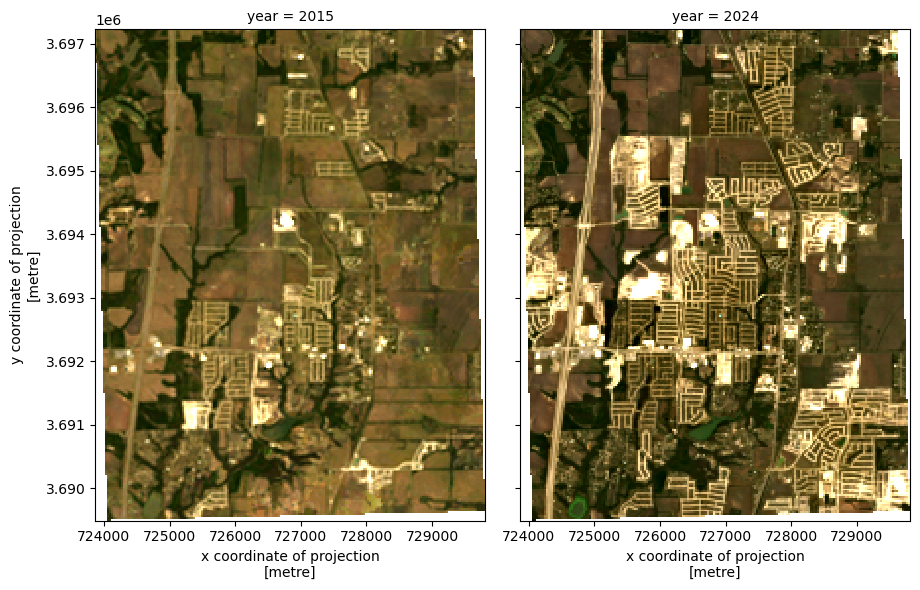

In [65]:
rgb(ds_mask_scaled,bands=['Red','Green','Blue'],col='year',aspect=0.7)

## 4.2. ENDISI Estimation
The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is a recently developed proxy for urbanization that has demonstrated strong performance across diverse environments (Chen et al., 2020). Like all normalized difference indices, ENDISI values range from -1 to 1. It incorporates variables such as MNDWI, `swir_diff`, and `alpha` as part of its calculation.

**Reference:**  
<font color="blue">[Chen et al. (2020), *Journal of Applied Remote Sensing*](https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-13/issue-01/016502/Enhanced-normalized-difference-index-for-impervious-surface-area-estimation-at/10.1117/1.JRS.13.016502.full)</font>




In [26]:
# Calculate the ENDISI index
blue_band = 'Blue'
green_band = 'Green'
swir1_band = 'SWIR_1'
swir2_band = 'SWIR_2'
ds_mask_scaled['ENDISI'] = ENDISI(ds_mask_scaled,blue_band,green_band,swir1_band,swir2_band)

Plot to show the urban areas

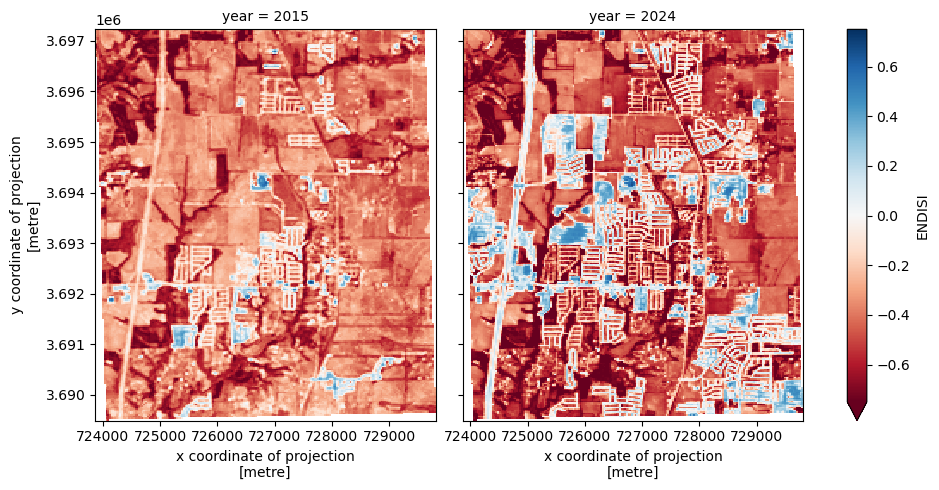

In [27]:
ds_mask_scaled.ENDISI.plot(col='year',vmin=-.75,
                       vmax=0.75,
                       cmap='RdBu',
                       figsize=(10, 5),
                       robust=True);

## 4.3. Calculate Urban Extent

To define the urban extent, we need to apply a threshold to the ENDISI arrays. Values above this threshold are classified as ‘Urban,’ while values below it are excluded. This threshold can be determined in various ways, including manual selection (e.g., ```threshold = -0.1```). In the example below, we use the Otsu method to automatically determine an optimal threshold for the image.


In [28]:
from skimage.filters import threshold_otsu
ds_mask_scaled_nan = ds_mask_scaled['ENDISI'].values.flatten()
ds_mask_scaled_nan = ds_mask_scaled_nan[~np.isnan(ds_mask_scaled_nan)]
threshold = threshold_otsu(ds_mask_scaled_nan)
print(round(threshold, 2))

-0.23


Apply the threshold to calculate urban extent

In [29]:
threshold = threshold
urban_area = (ds_mask_scaled.ENDISI > threshold).astype(int)

Plotting the non-urban and urban areas for 2015 and 2024

[Text(1, 0.5, 'Non-urban'), Text(1, 1.1, 'Urban')]

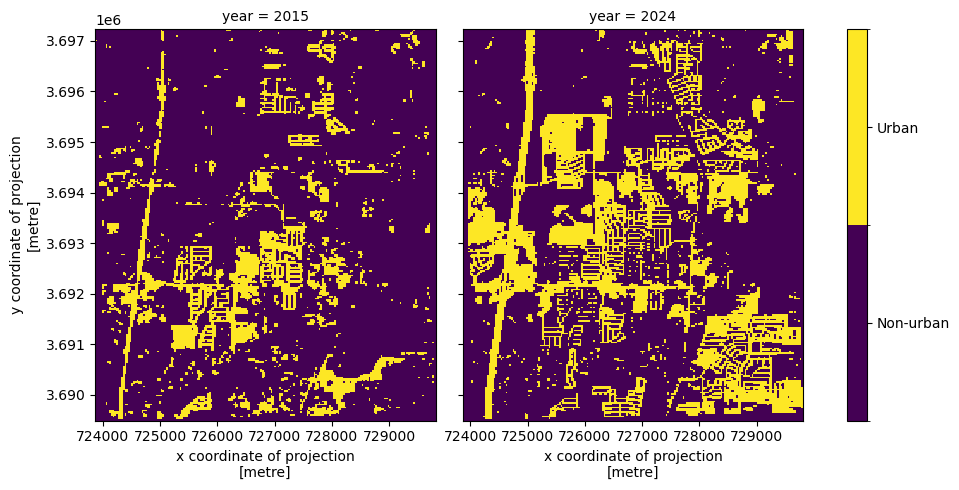

In [30]:
img = urban_area.plot(
    col='year',
    figsize=(10, 5),
    robust=True,
    vmin=0,
    vmax=1,
    add_colorbar=True,
    levels=[0,1,1.2]
)
# Modifying the colorbar to make the labels more intuniative
fig = img.fig
cbar = fig.axes[-1]  # The colorbar is usually the last axes in the figure
cbar.set_ylabel('')
cbar.set_yticks([0.5,1.1])
cbar.set_yticklabels(['Non-urban','Urban'])

## 4.7 Urban change

By subtracting the ENDISI values of the baseline year from those of the analysis year, we can highlight areas experiencing urban growth. To avoid capturing noise or minor fluctuations, we apply a change threshold that distinguishes true urban expansion from background variation.

The resulting plot reveals regions with significant change, effectively highlighting areas of urbanization.

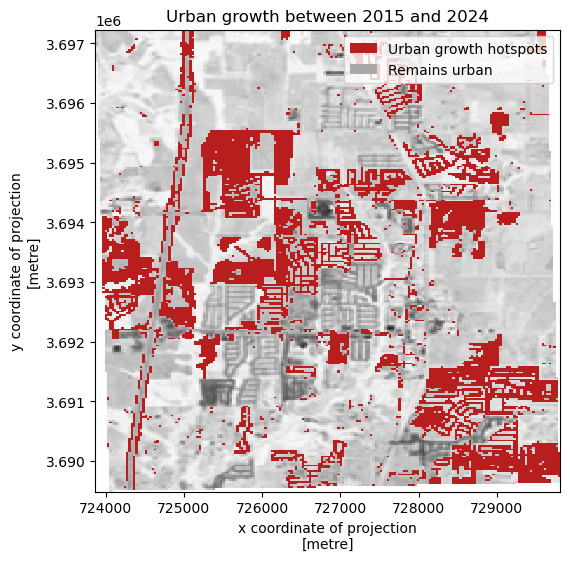

In [31]:
urban_growth_plot(ds_mask_scaled,urban_area,baseline_year,analysis_year)

### **Conclusion**
In this tutorial, we demonstrated how to search, subset, and analyze Harmonized Landsat Sentinel-2 (HLS) data using Python tools and NASA’s CMR-STAC API. We addressed challenges related to data retrieval and granule filtering, showed how to load and process large datasets efficiently with Dask, and applied urbanization indices like ENDISI to assess changes over time. This workflow provides a practical approach to monitoring urban growth with high-resolution satellite data, empowering researchers and practitioners to make data-driven decisions in environmental and urban studies.


### **Acknowledgements**  
The Harmonized Landsat Sentinel-2 (HLS) solution is funded by NASA and was developed to address data needs identified by the U.S. Federal Government through the Satellite Needs Working Group (SNWG) biennial survey.



### **Contact Information**  
- **Author**: Trang Vo  
- **Contributors**: Madhu Sridhar, Chuck Daniels, Chris Holden, Sean Harkins  
- **Email**: tv0015@uah.edu  
- **Organization**: NASA MSFC IMPACT Project – HLS Production Team  
- **Last Modified**: July 3, 2025  



### **References**  
- <font color="blue">[HLS Product Information](https://www.earthdata.nasa.gov/data/projects/hls)</font>
- <font color="blue">[Getting Started with Cloud-Native HLS Data in Python](https://lpdaac.usgs.gov/resources/e-learning/getting-started-cloud-native-hls-data-python/)</font>
- <font color="blue">[The Harmonized Landsat and Sentinel-2 version 2.0 surface reflectance dataset](https://www.sciencedirect.com/science/article/pii/S0034425725001270)</font>
- <font color="blue">[Toward Seamless Global 30-m Terrestrial Monitoring: Evaluating 2022 Cloud Free Coverage of Harmonized Landsat and Sentinel-2 (HLS) V2.0](https://ieeexplore.ieee.org/abstract/document/10852289)</font>

